In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.model_selection import train_test_split

from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, CuDNNLSTM, LSTM, Conv1D,UpSampling1D, MaxPool1D,MaxPooling1D, Permute, Reshape
from keras.optimizers import RMSprop, adam
from keras.utils import to_categorical

import pywt
import pandas as pd
from matplotlib import cm

from mpl_toolkits.mplot3d import Axes3D

from imblearn.over_sampling import SMOTE
from imblearn.base import BaseSampler
from collections import Counter # counts the number of elements per class ({0: 5050, 1: 37})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
def RPN(x):
    '''
    Calcule la RPN d'un signal (Relative Power Noise)
    input :
        x = array numpy, le signal dont on souhaite calculer la RPN
        
    output :
        x_RPN = array numpy, la RPN du signal
        '''
    mean = np.mean(x,axis=1).reshape(x.shape[0],1)
    return (x-mean)/mean
  
def shuffle(x,y):
    # shuffle
    index = np.arange(y.shape[0])
    np.random.shuffle(index)
    x = x[index]
    y = y[index]
    
    return x,y
    
def bootstrap(x_train,y_train,inv=True) :
    if inv :
      x_train,y_train = inv_data(x_train,y_train)
      
    x_train1 = x_train[np.where(y_train == 1)[0]] #Separation du train_set selon le label
    x_train0 = x_train[np.where(y_train == 0)[0]]
    index_train = np.random.randint(0,x_train1.shape[0] , size=x_train0.shape[0]) #genere une liste d'index 
                                                                                  #aléatoire pour equilibrer les données
    x_train_1_boot = x_train1[index_train]
    y_train_boot = np.concatenate((np.ones(x_train0.shape[0]),np.zeros(x_train0.shape[0]))) #on génère une liste de labels avec autant de 1 que de 0
    x_train_boot = np.concatenate((x_train_1_boot,x_train0)) #on rassemble les données une fois équilibrées
    
    x_train_boot,y_train_boot  = shuffle(x_train_boot,y_train_boot)
    
    return x_train_boot,y_train_boot

def dataload(path='data/',merge=True) :
    # Loading datas
    data_train = pd.read_csv(path+'exoTrain.csv')
    data_test = pd.read_csv(path+'exoTest.csv')
    
    # transformation des label en array de 0 et 1
    y_train = np.array(data_train["LABEL"])-1
    y_test = np.array(data_test['LABEL'])-1
    
    # on charge les features
    x_train = np.array(data_train.drop('LABEL',axis=1))
    x_test = np.array(data_test.drop('LABEL',axis=1))
    
    if merge :
      data = np.concatenate((x_train,x_test))
      y = np.concatenate((y_train,y_test))
      data0 = data[np.where(y==0)[0]]
      y0 = y[np.where(y==0)[0]]
      data1 = data[np.where(y==1)[0]]
      y1 = y[np.where(y==1)[0]]
      
      x_train0,x_test0,y_train0,y_test0 = train_test_split(data0,y0, test_size = 0.1)
      x_train1,x_test1,y_train1,y_test1 = train_test_split(data1,y1, test_size = 0.1)
      
      x_train = np.concatenate((x_train0,x_train1))
      y_train = np.concatenate((y_train0,y_train1))
      x_test = np.concatenate((x_test0,x_test1))
      y_test = np.concatenate((y_test0,y_test1))
      
      x_train,y_train = shuffle(x_train,y_train)
      x_test,y_test = shuffle(x_test,y_test)
    
    return x_train,y_train,x_test,y_test

def pcaPlot(X, y, descr= 'temporel',plot_samples = 500):
  '''
  Defines and 10 components PCA of the dataset X and plots the first 3
  '''
  pca = PCA(n_components=10)
  x_PCA = pca.fit_transform(X)

  # let's visualize the data in 3d
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_zlabel('Principal Component 3', fontsize = 15)
  ax.set_title('ACP du signal ' + descr, fontsize = 20)
  targets = [0,1]
  colors = ['b', 'r']
  x_PCA_plot = x_PCA[0:plot_samples]

  for target, color in zip(targets,colors):
      indexes = np.where(y[0:plot_samples] == target)
      ax.scatter(x_PCA_plot[indexes,0]
                , x_PCA_plot[indexes,1],
                x_PCA_plot[indexes,2]
                , c = color
                , s = 50)
  ax.legend(['pas d\'exoplanetes', 'exoplanetes'])
  ax.grid()
  plt.show()
  return None

#Make an identity sampler
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y

def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def SMOTE_plot(x_train, y_train):
  sampler = FakeSampler()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  plot_resampling(x_train, y_train, sampler, ax1)
  ax1.set_title('Original data - y={}'.format(Counter(y_train)))

  plot_resampling(x_train, y_train, SMOTE(random_state = 0), ax2)
  ax2.set_title('Resampling using {}'.format(SMOTE(random_state=0).__class__.__name__))
  fig.tight_layout()
  plt.show()
  return None

def transform_dataset(X, mode='wavelet', wname='db5',nsamples=10):
  if mode == 'wavelet':
    return pywt.dwt(X, wname)[0][:,0:nsamples]

  elif mode == 'fft':
    return np.abs(np.fft.fft(X))[:,0:nsamples]

  elif mode == 'all_in':
    allz = np.abs(np.fft.fft(X))[:,0:nsamples]
    wnames = ['db5','sym5','coif5','bior2.4']
    for wn in wnames:
      np.append(allz, pywt.dwt(X, wn)[0][:,0:nsamples], axis=1)
    return allz

def scale_datasets(X_train, X_test, param='standardScaling', reshape=True):
  SC = StandardScaler()
  train_shape = X_train.shape
  test_shape = X_test.shape
    
  if param == 'standardScaling':
    SC.fit(X_train)
    if reshape:
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1],1), SC.transform(X_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return SC.transform(X_train), SC.transform(X_test)
    
  elif param == 'transpose':
    X_train = np.transpose(X_train)
    if train_shape != test_shape :
      X_test = np.tile(X_test,(10,1))[0:train_shape[0]]
    X_test = np.transpose(X_test)
    SC.fit(X_train)
    if reshape:
      return np.transpose(SC.transform(X_train)).reshape(train_shape[0],train_shape[1],1), np.transpose(SC.transform(X_test))[0:test_shape[0]].reshape(test_shape[0],test_shape[1],1)
    else :
      return np.transpose(SC.transform(X_train)), np.transpose(SC.transform(X_test))[0:test_shape[0]]
    
  elif param == 'flatten':
    X_train = X_train.flatten().reshape((-1,1))
    X_test = X_test.flatten().reshape((-1,1))
    SC.fit(X_train)
    if reshape:
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1],1), SC.transform(X_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1]), SC.transform(X_test).reshape(test_shape[0],test_shape[1])
  
  elif param == 'norm':
    norm_train = np.linalg.norm(X_train,axis=1).reshape(-1,1)
    norm_test = np.linalg.norm(X_test,axis=1).reshape(-1,1)
    if reshape:
      return (X_train/norm_train).reshape(train_shape[0],train_shape[1],1), (X_test/norm_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return X_train/norm_train, X_test/norm_test
    
  elif param == 'norm_flatten':
    norm_train = np.linalg.norm(X_train)
    norm_test = np.linalg.norm(X_test,axis=1).reshape(-1,1)
    if reshape:
      return (X_train/norm_train).reshape(train_shape[0],train_shape[1],1), (X_test/norm_train).reshape(test_shape[0],test_shape[1],1)
    else :
      return X_train/norm_train, X_test/norm_train

def inv_data(X, y):
  X_flipped = np.flip(X[np.where(y == 1)[0]], 1)
  y_flipped = np.ones((X_flipped.shape[0]))
  return np.concatenate((X, X_flipped)), np.concatenate((y, y_flipped))

In [0]:
def getScores(pred, result):
  print('Precision :')
  print(precision_score(result, pred))

  print('Recall :')
  print(recall_score(result, pred))

  print('F1 Score :')
  scoref1 = f1_score(result, pred)
  print(scoref1)

  print('MSE :')
  modelError = mean_squared_error(result, pred)
  print(modelError)

  print('')
  print('confusion_matrix : ')
  confusion = confusion_matrix(result, pred)
  print(confusion)
  print('')
  return scoref1, modelError, confusion

def recall(y_true, y_pred):
  """Recall metric.
  Only computes a batch-wise average of recall.
  Computes the recall, a metric for multi-label classification of
  how many relevant items are selected.
  """
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
  """Precision metric.
  Only computes a batch-wise average of precision.
  Computes the precision, a metric for multi-label classification of
  how many selected items are relevant.
  """
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  return true_positives / (predicted_positives + K.epsilon())

def f1(y_true, y_pred):
  preci = precision(y_true, y_pred)
  rec = recall(y_true, y_pred)
  return 2*((preci*rec)/(preci+rec+K.epsilon()))

def auto_encoder(X, X_tst):
  #X = X.reshape(-1,1)
  #X_tst = X_tst.reshape(-1,1)
  autoencoder = Sequential()

  # Encoder
  autoencoder.add(Conv1D(16, 10, activation='relu', padding='same', input_shape=X.shape[1:]))
  autoencoder.add(MaxPooling1D(4, padding='same'))
  autoencoder.add(Conv1D(8, 4, activation='relu', padding='same'))
  autoencoder.add(MaxPooling1D(4, padding='same'))
  autoencoder.add(Conv1D(1, 4, activation='sigmoid', padding='same'))

  # Decoder
  autoencoder.add(Conv1D(8, 4, activation='relu', padding='same'))
  autoencoder.add(UpSampling1D(4))
  autoencoder.add(Conv1D(8, 4, activation='relu', padding='same'))
  autoencoder.add(UpSampling1D(4))
  autoencoder.add(Conv1D(1, 4, activation='tanh'))
  
  '''
  autoencoder.add(UpSampling1D(4))
  autoencoder.add(Conv1D(1, 4, activation='sigmoid', padding='same'))
  '''
  autoencoder.summary()



  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.fit(X, X,
                  epochs=10,
                  batch_size=128,
                  validation_data=(X_tst, X_tst))

  encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv1d_3').output)
  encoder.summary()

  X_encoded = encoder.predict(X)
  X_tst_encoded = encoder.predict(X_tst)

  return X_encoded, X_tst_encoded, autoencoder


In [5]:
plt.close('all')

x_train, y_train, x_test, y_test = dataload(merge=True, path='drive/My Drive/M1/IA/')

# création du vecteur temps (h)
t = np.arange(len(x_train[0])) * (36.0/60.0)
dt = 36 * 60  # sampling rate (s) les données sont prises avec 36min d'écart
f = np.fft.fftfreq(x_train.shape[1], dt)  # vecteur fréquence en (Hz)

x_train, y_train = bootstrap(x_train, y_train)
x_train = RPN(x_train)
x_test = RPN(x_test)

X_encoded, X_tst_encoded, autoencoder = auto_encoder(x_train, x_test)





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3197, 16)          176       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 800, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 800, 8)            520       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 200, 8)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 8)            264       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 8)            264       
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 800, 8)       

In [0]:
def simple_net(X,y, X_tst, y_tst):
  '''
  Defines and fits a NN sequential model on X and y. It then tests the model with X_tst and y_tst
  '''

  # Specify model
  model = Sequential()

  model.add(Conv1D(filters=16, kernel_size=11,
                    activation='softsign', input_shape=X.shape[1:]))
  model.add(MaxPool1D(strides=4))
  model.add(Flatten())
  model.add(Dropout(0.45))

  model.add(Reshape((-1, 1)))
  
  model.add(CuDNNLSTM(32, return_sequences=True))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(0.45))

  model.add(Dense(1, activation="sigmoid"))

  model.summary()
  model.compile(loss="binary_crossentropy",
                optimizer=adam(),
                metrics=[f1, precision, "accuracy"])

  # Parameters
  batch_size = 250
  epochs = 20
  
  # Perform fit
  history = model.fit(X, y,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      shuffle=True,
                      validation_data=(X_tst, y_tst))

  # Print results
  score = model.evaluate(X_tst, y_tst, verbose=0)
  print('Test loss/accuracy: %g, %g' % (score[0], score[1]))

  plt.figure(figsize=(15, 5))
  # Plot history for accuracy
  plt.subplot(121)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy -- MLP')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss -- MLP')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.tight_layout()

  return model, model.predict(x=X_tst)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 190, 16)           1424      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 48, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 768, 1)            0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 768, 32)           4480      
____

(0.1, 0.031746031746031744, array([[548,   4],
        [ 14,   1]]))

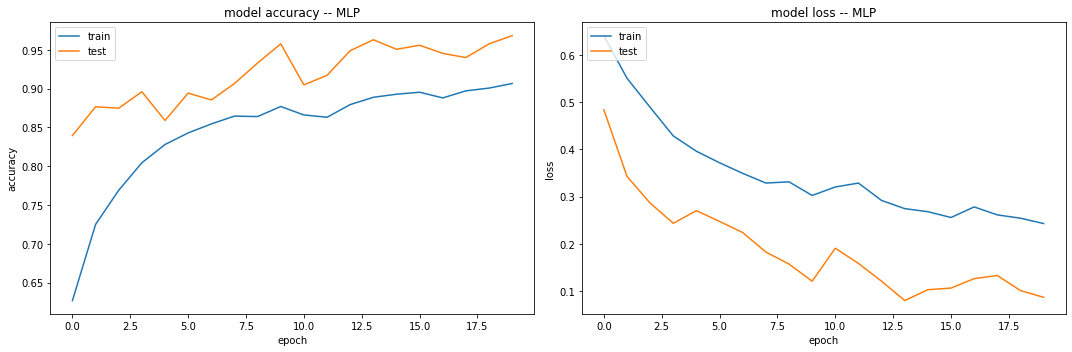

In [7]:
simple_model, simple_y_pred = simple_net(X_encoded, y_train, X_tst_encoded, y_test)
predthr = np.where(simple_y_pred > 0.5, 1, 0)
getScores(y_test, predthr)